In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [3]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Preprocessing (same as kaggle analysis):

In [4]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,curbweight_squared,enginesize_squared,boreratio_squared,stroke_squared,compressionratio_squared,horsepower_squared,peakrpm_squared,citympg_squared,highwaympg_squared,log_enginesize
0,1,3,alfa-romero giulia,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
1,2,3,alfa-romero stelvio,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
2,3,1,alfa-romero Quadrifoglio,1,0,1,2,2,0,-0.708596,...,7969329,23104,7.1824,12.0409,81.0,23716,25000000,361,676,5.030438
3,4,2,audi 100 ls,1,0,0,3,1,0,0.173698,...,5461569,11881,10.1761,11.5600,100.0,10404,30250000,576,900,4.700480
4,5,2,audi 100ls,1,0,0,3,0,0,0.107110,...,7974976,18496,10.1761,11.5600,64.0,13225,30250000,324,484,4.919981


<Axes: xlabel='price', ylabel='Count'>

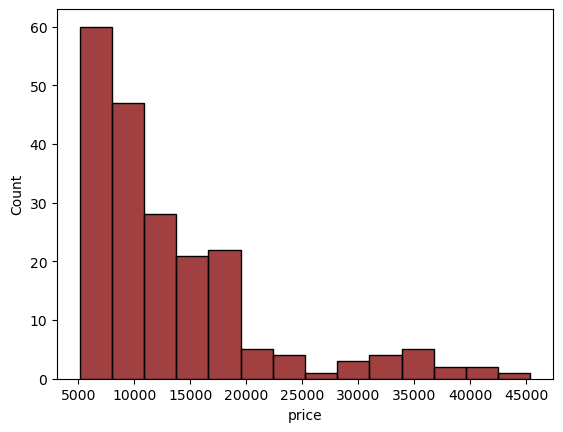

In [5]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

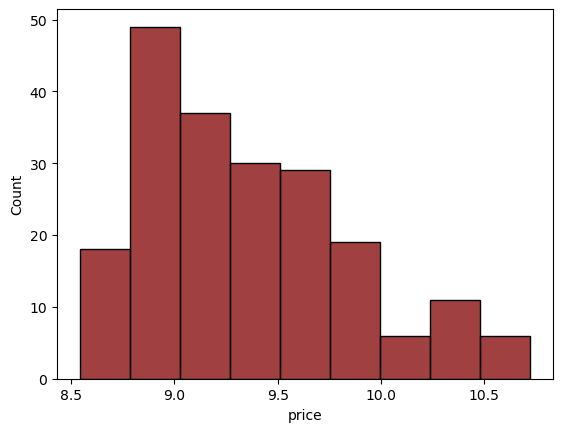

In [6]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

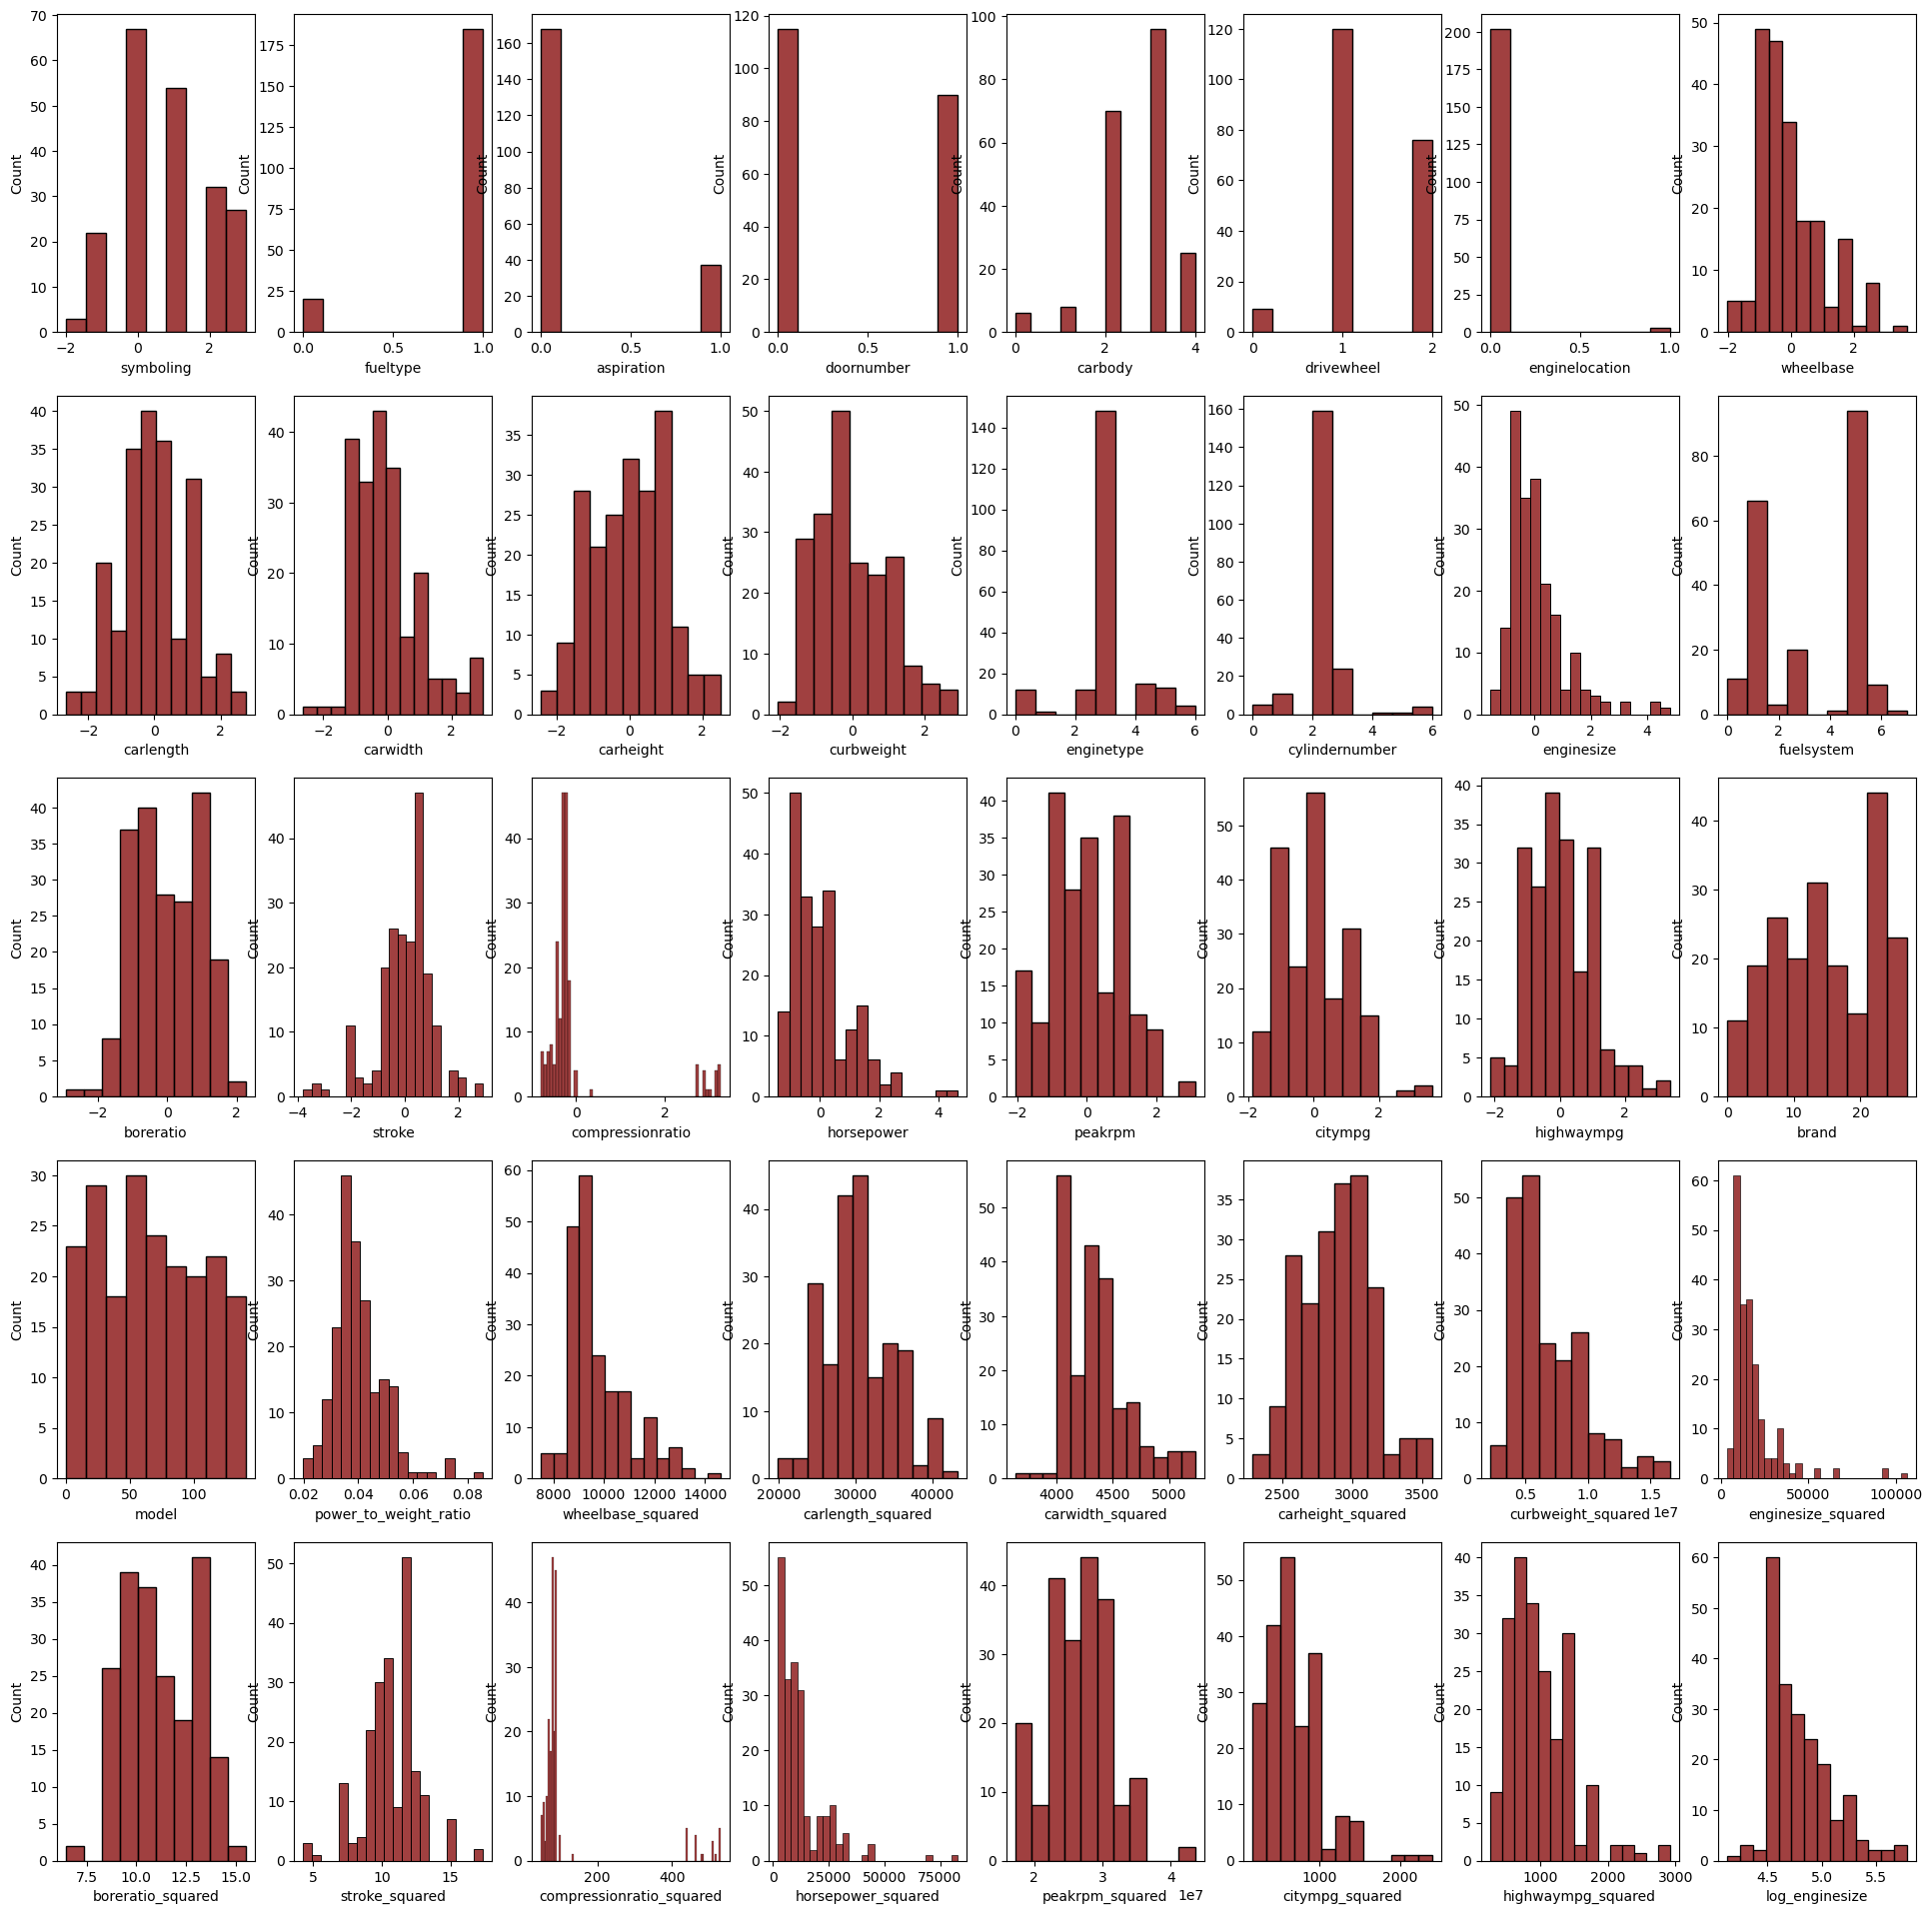

In [7]:
# Inspect histplots of all features
_, ax = plt.subplots(5, 8, figsize=(24, 24))
ax = ax.flatten()
cols = np.array(data.columns)
cols = cols[cols != 'car_ID']
cols = cols[cols != 'CarName']
cols = cols[cols != 'price']
for col, a in zip(cols, ax):
    sns.histplot(data[col], ax=a, color='maroon')

In [8]:
# Use all possible features (don't use squared or logged features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio'],
      dtype='object')

In [9]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [10]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [11]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 9.2,
    'sd3': 9.2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: 34.6s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (190

In [12]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,209.896267,0.999937,0.016242,8.0,255.0,0.0,-202.650259,0.171059,8.722298,-0.015650,...,9.195107,9.007648,9.949979,9.239986,10.231775,9.179128,9.153307,8.591919,9.460366,9.002012
1,216.183188,0.946419,0.015635,8.0,255.0,0.0,-201.113925,0.151009,8.416634,0.021702,...,8.852085,8.694460,9.945566,8.766132,10.248337,9.077919,9.300990,9.021130,9.564696,8.950145
2,221.088019,0.984150,0.013880,8.0,511.0,0.0,-211.366577,0.151874,8.279797,-0.000462,...,8.673987,8.885573,9.830391,8.918094,10.364475,9.314381,9.104420,8.762333,9.529837,9.107918
3,209.037729,0.865913,0.017115,8.0,255.0,0.0,-192.003412,0.158106,8.643170,-0.024204,...,8.590284,8.584221,9.791836,9.118632,10.071289,9.289651,9.298752,8.680415,9.720778,8.925452
4,213.013140,0.989632,0.016242,8.0,255.0,0.0,-202.275960,0.158419,8.616268,-0.008528,...,9.125219,8.841354,9.942418,9.113098,10.346084,9.324842,9.513803,8.617315,9.499895,8.813831


In [13]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.153,0.009,0.136,0.170,0.000,0.000,8134.0,5920.0,1.0
alpha,8.382,0.483,7.483,9.290,0.009,0.006,3160.0,4512.0,1.0
beta[0],-0.002,0.017,-0.034,0.029,0.000,0.000,7237.0,5760.0,1.0
beta[1],0.894,0.407,0.123,1.651,0.007,0.005,3630.0,4528.0,1.0
beta[2],0.053,0.054,-0.048,0.156,0.001,0.001,5429.0,6006.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.271,0.171,8.963,9.601,0.002,0.001,7801.0,7877.0,1.0
pred_y[37],9.331,0.174,8.998,9.650,0.002,0.001,8561.0,7770.0,1.0
pred_y[38],8.738,0.167,8.427,9.050,0.002,0.001,7867.0,7719.0,1.0
pred_y[39],9.520,0.161,9.216,9.829,0.002,0.001,8426.0,7962.0,1.0


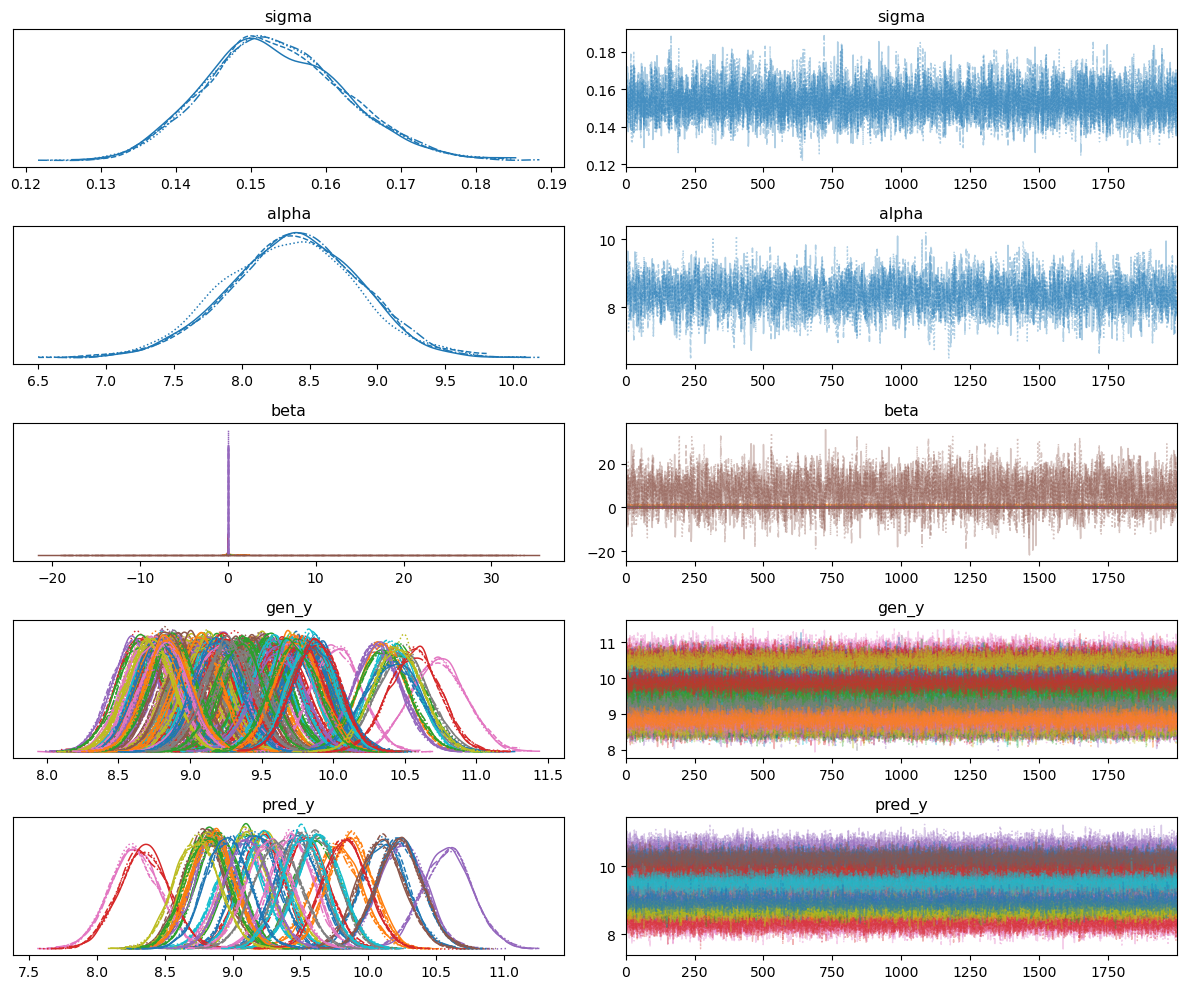

In [14]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

In [15]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.1395116820653617
R2-Score: 0.9214847942232137


In [16]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.18166933855261805
R2-Score: 0.8783610163562063


In [19]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([-1.81501565e-03,  8.94039756e-01,  5.26689337e-02, -7.29091346e-02,
       -6.90726329e-02,  3.72702317e-02,  4.83890169e-01,  2.38803610e-02,
        2.24538881e-02,  5.43795414e-02,  3.12348264e-02,  2.07338332e-01,
        1.25999890e-02, -1.13587784e-02,  3.73133901e-02,  3.29316391e-02,
        5.52642095e-03, -2.20827195e-02,  3.31833666e-01, -2.56523697e-02,
        2.46360331e-02, -1.79573479e-01,  8.82965169e-02, -9.30186469e-03,
        4.65501834e-04,  7.23602429e+00])